In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(gridlines=':')

In [2]:
PLAYER_B = 1
PLAYER_W = -PLAYER_B
CELL_EMPTY = 0
DIRNS = np.array([(xs, ys) for xs in [-1, 0, 1] for ys in [-1, 0, 1] if xs or ys])

def shift_indices(shift, side):
    """get indices for shifting array in one dimension"""
    if shift == 0:
        orig_idx = range(side)
        shifted_idx = range(side)
    elif shift > 0:
        orig_idx = range(side - shift)
        shifted_idx = range(shift, side)
    elif shift < 0:
        orig_idx = range(-shift, side)
        shifted_idx = range(side + shift)
    else:
        orig_idx, shifted_idx = None, None
    return orig_idx, shifted_idx

class Board(object):
    side = 8
    _stash_board = None
    _stash_turn = None
    
    def __init__(self):
        """Reset board to starting position"""
        self.reset()
    
    def reset(self):
        """Reset board to starting position"""
        self.turn = PLAYER_B
        self.board = np.zeros((self.side, self.side), dtype=np.int8)
        # 1 = black, -1 = white
        self.board[4, 3] = 1
        self.board[3, 4] = 1
        self.board[3, 3] = -1
        self.board[4, 4] = -1
    
    def stash(self):
        self._stash_board = self.board.copy()
        self._stash_turn = self.turn
        
    def pop(self):
        self.board = self._stash_board.copy()
        self.turn = self._stash_turn
    
    def candidate_moves(self):
        """List neighbours that would make turn candidates
        a cell is a good candidate if (a) it is empty and (b) any neighbour is the opposite of self.turn
        """
        empty_cells = np.zeros((self.side, self.side), dtype=np.int8)
        empty_cells[self.board == CELL_EMPTY] = 1
        # suitable neighbours with opponents stones
        opponent_cells = np.zeros((self.side, self.side), dtype=np.int8)
        opponent_cells[self.board == self.opponent] = 1
        # 8 possible directions to a neighbour
        shifts = DIRNS
        # an 8x8x9 array of conditions 
        neighbour_array = np.zeros((len(shifts), self.side, self.side), dtype=np.int8)
        for idx, (rs, cs) in enumerate(shifts):
            ridx_orig, ridx_shifted = shift_indices(rs, self.side)
            cidx_orig, cidx_shifted = shift_indices(cs, self.side)
            neighbour_array[np.ix_([idx], ridx_shifted, cidx_shifted)] = opponent_cells[np.ix_(ridx_orig, cidx_orig)]
        # cells that have a neighbour of opponent's colour
        cells_with_opponent_neighbours = np.any(neighbour_array, axis=0)
        candidates = np.logical_and(empty_cells, cells_with_opponent_neighbours)
        return np.vstack(np.where(candidates)).T
    
    def move(self, r, c):
        """Attempt to place the next piece at (r, c)
        Turn is decided based on self.turn
        """
        # if we are trying to place in a non-empty cell, return
        if self.board[r, c] != CELL_EMPTY:
            return False   
        
        # else, try to turn along each diagonal
        turned_idx = []
        for (rs, cs) in DIRNS:
            rr, cc = r + rs, c + cs
            diag_turned_idx = []
            diag_terminated = False
            # proceed until we hit an edge, or an empty cell, or our own cell
            while 0 <= rr and rr < self.side and 0 <= cc and cc < self.side:
                if self.board[rr, cc] == self.opponent: # continue along unbroken line of opponent's stones
                    diag_turned_idx += [(rr, cc)]
                    rr, cc = rr + rs, cc + cs
                elif self.board[rr, cc] == self.player: # terminate at our own stone
                    diag_terminated = True
                    break
                elif self.board[rr, cc] == CELL_EMPTY: # terminate (unsuccesfully) at an empty cell
                    break
            # if diagonal completed successfully, append cells to be turned
            if diag_terminated:
                turned_idx += diag_turned_idx
        
        # if we have turned stones along any of the diagonals
        if turned_idx:
            turned_idx += [(r, c)]
            ridx, cidx = zip(*turned_idx)
            self.board[ridx, cidx] = self.player
            self.turn = self.opponent
            return True
        else:
            return False
    
    def legal_moves(self):
        self.stash()
        moves = []
        for (mr, mc) in self.candidate_moves():
            if self.move(mr, mc):
                moves.append((mr, mc))
            self.pop()
        return moves
    
    def pass_move(self):
        self.turn = self.opponent
        
    @property
    def player(self):
        """current player"""
        return self.turn
    
    @property
    def opponent(self):
        """opponent player"""
        return -self.turn
    
    @property
    def score(self):
        """Compute totals for each player"""
        counts = dict(zip(*np.unique(self.board, return_counts=True)))
        if 1 not in counts:
            counts[1] = 0
        if -1 not in counts:
            counts[-1] = 0    
        b, w = counts[1], counts[-1]
        return b, w
    
    @property
    def ordered_score(self):
        b, w = self.score
        if self.player is PLAYER_B:
            return b, w
        else:
            return w, b
            
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        """Return a string representation of the board"""
        SHOW_COORDS = True
        chars = {
            CELL_EMPTY: ".",
            PLAYER_B: "Ø",  #®
            PLAYER_W: "O",  #©
        }
        def row_str(row):
            cell_chars = [chars[r] for r in row]            
            return ''.join(cell_chars)
        row_strings = [row_str(row) for row in self.board]
        if SHOW_COORDS:
            row_strings = ['%d %s' % (idx, rs) for idx, rs in enumerate(row_strings)]
            header_row = ''.join(['%d' % d for d in range(self.side)])
            header_row = '  ' + header_row
            row_strings = [header_row] + row_strings
        score_string = 'Score: B=%d, W=%d' % self.score
        turn_string = 'Next turn: %s [%s]' % ('B' if self.turn == PLAYER_B else 'W', chars[self.turn])
        return '\n'.join([score_string, turn_string] + row_strings)

class Game(object):
    """Run a game between two players"""
    def __init__(self, playerB=None, playerW=None):
        self.board = Board()
        self.playerB = playerB
        self.playerW = playerW
        playerB.board = self.board
        playerW.board = self.board
    
    @property
    def current_player(self):
        if self.board.turn == PLAYER_B:
            return self.playerB
        else:
            return self.playerW
        
    def play(self, reset=False, verbose=0):
        """run a game"""
        if reset:
            self.board.reset()
        passes = 0
        while passes < 2:
            if not self.board.legal_moves():
                self.board.pass_move()
                passes += 1
            else:
                passes = 0
                self.current_player.play()
            if verbose:
                print self.board
        final_score = self.board.score
        return final_score
    
class Player(object):
    """Meta-class for a player"""
    def __init__(self, board=None):
        self.board = board
    
    def decide(self):
        """Return (r, c) of desired move"""
        return (None, None)
    
    def play(self):
        r, c = self.decide()
        if r is None or c is None:
            raise ValueError("Decided move must not be None")
        legal = self.board.move(r, c)
        if not legal:
            raise ValueError("Illegal move attemted: (%d, %d)" % (r, c))
    
class Player_Random(Player):
    """A player who picks a valid turn at random"""
    def __init__(self, board=None):
        super(Player_Random, self).__init__(board)
    
    def decide(self):
        moves = self.board.legal_moves()
        return moves[np.random.randint(0, len(moves))]
        
class Player_Greedy(Player):
    """A player who picks a turn leading to maximum gains"""
    def __init__(self, board=None):
        super(Player_Greedy, self).__init__(board)
    
    def decide(self):
        self.board.stash()
        best_move = (None, None)
        best_score = -64
        for (mr, mc) in self.board.candidate_moves():
            if self.board.move(mr, mc):
                plr, opp = self.board.ordered_score
                score = opp - plr # board player has been updated!
                if score > best_score:
                    best_score = score
                    best_move = (mr, mc)
            self.board.pop()
        return best_move
    
class Player_Weighted(Player):
    """A player who picks a turn leading to maximum value as determined by weights
    see e.g. weights here: http://www.samsoft.org.uk/reversi/strategy.htm"""
    WEIGHTS = np.array([
        [99, -8, 8, 6, 6, 8, -8, 99],
        [-8,-24,-4, -3, -3, -4, -24, -8],
        [8, -4, 7, 4, 4, 7, -4, 8],
        [6, -3, 4, 0, 0, 4, -3, 6],
        [6, -3, 4, 0, 0, 4, -3, 6],
        [8, -4, 7, 4, 4, 7, -4, 8],
        [-8,-24,-4, -3, -3, -4, -24, -8],
        [99, -8, 8, 6, 6, 8, -8, 99]
    ])
    def __init__(self, board=None):
        super(Player_Weighted, self).__init__(board)
    
    def decide(self):
        self.board.stash()
        best_move = (None, None)
        best_score = -64*99
        for (mr, mc) in self.board.candidate_moves():
            if self.board.move(mr, mc):
                # board player has been updated!
                score = -self.board.player*(self.board.board * self.WEIGHTS).sum()
                if score > best_score:
                    best_score = score
                    best_move = (mr, mc)
            self.board.pop()
        return best_move

In [3]:
b = Board()
b.stash()
print b.legal_moves()
print b.move(0,3)
print b.move(2,3)
print b.move(2,2)
print b.move(3,2)
print b
print b.legal_moves()

[(2, 3), (3, 2), (4, 5), (5, 4)]
False
True
True
True
Score: B=5, W=2
Next turn: W [O]
  01234567
0 ........
1 ........
2 ..OØ....
3 ..ØØØ...
4 ...ØO...
5 ........
6 ........
7 ........
[(2, 4), (4, 2)]


### Random vs Random

In [154]:
%%time
g = Game(playerB=Player_Random(), playerW=Player_Random())
scores = np.array([g.play(reset=True) for _ in range(200)])

CPU times: user 1min 1s, sys: 16 ms, total: 1min 1s
Wall time: 1min 1s


Black wins: 99/200


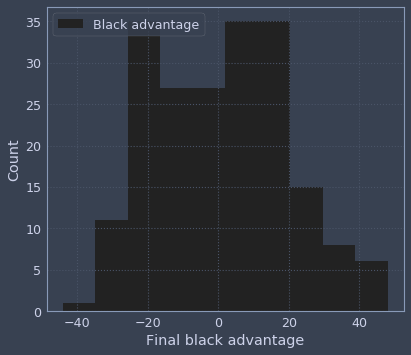

In [155]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');

### Greedy vs Random

In [191]:
%%time
g = Game(playerB=Player_Greedy(), playerW=Player_Random())
scores = np.array([g.play(reset=True) for _ in range(200)])

CPU times: user 57.5 s, sys: 24 ms, total: 57.6 s
Wall time: 57.5 s


Black wins: 138/200


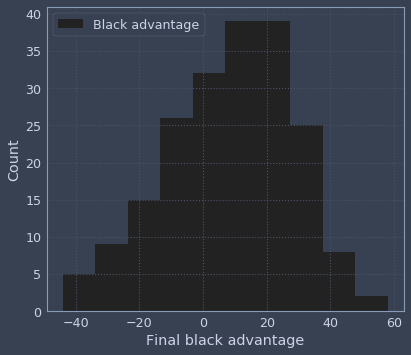

In [192]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');

### Random vs Greedy

In [193]:
%%time
g = Game(playerB=Player_Random(), playerW=Player_Greedy())
scores = np.array([g.play(reset=True) for _ in range(200)])

CPU times: user 1min 1s, sys: 104 ms, total: 1min 1s
Wall time: 1min


Black wins: 62/200


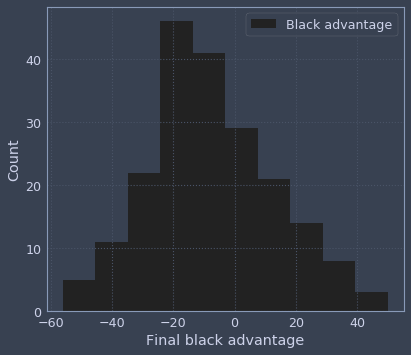

In [194]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');

### Random vs Weighted

In [195]:
%%time
g = Game(playerB=Player_Random(), playerW=Player_Weighted())
scores = np.array([g.play(reset=True) for _ in range(200)])

CPU times: user 1min, sys: 124 ms, total: 1min
Wall time: 1min


Black wins: 30/200


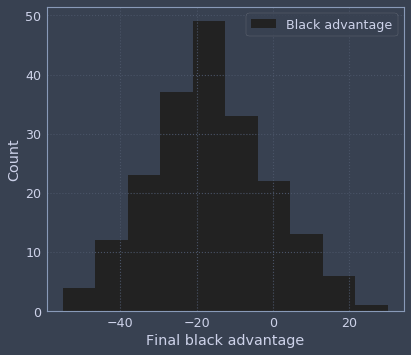

In [196]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');

### Weighted vs Greedy

In [4]:
%%time
g = Game(playerB=Player_Weighted(), playerW=Player_Greedy())
scores = np.array([g.play(reset=True) for _ in range(10)])

CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 2.98 s


Black wins: 10/10


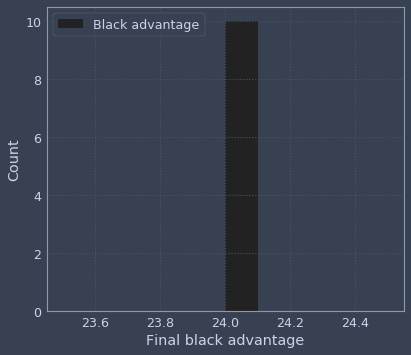

In [5]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');

### Weighted vs Random

In [197]:
%%time
g = Game(playerB=Player_Weighted(), playerW=Player_Random())
scores = np.array([g.play(reset=True) for _ in range(200)])

CPU times: user 1min 2s, sys: 20 ms, total: 1min 2s
Wall time: 1min 2s


Black wins: 176/200


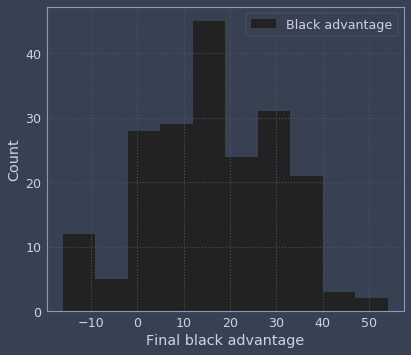

In [198]:
b_wins = np.count_nonzero(scores[:, 0] > scores[:, 1])
total_games = len(scores)
print 'Black wins: %d/%d' % (b_wins, total_games)

plt.hist(scores[:, 0] - scores[:, 1], label='Black advantage', color='k')
plt.legend()
plt.xlabel('Final black advantage')
plt.ylabel('Count');